In [42]:
import pandas as pd
import numpy as np 

import torch 
import torchvision.models as models
from torchvision import datasets, transforms
from torch import nn
from torch import optim

from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
# use gpu if available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print()
print("Device: ", device)


Device:  cuda:1


In [3]:
features_dim = 512 # number of features before the classifier

class Webnet(nn.Module):
    def __init__(self):
        super(Webnet, self).__init__()
        
        resnet = models.resnet18(pretrained=True)
        
        self.features = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.fc = torch.nn.Linear(features_dim, out_dim)

    def forward(self, x):
        x = self.features(x).reshape(-1, features_dim)
        x = self.fc(x)
        return x

In [4]:
model = torch.load('/scratch/lugeon/webnets/webnet_04-12-20_13-05').to(device)

/scratch/lugeon/dl-env/lib/python3.8/site-packages/torch/serialization.py:622: UserWarning: Couldn't retrieve source code for container of type Webnet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [5]:
path = '/dlabdata1/lugeon/websites_alexa_mp2_1500_9cat_screenshots/valid'

batch_size = 32

# dimensions of the screeshots
valid_xdim = 640 # 640
valid_ydim = 360 # 360
crop_factor = 1

crop_dim = [int(crop_factor * valid_ydim), int(crop_factor * valid_xdim)]

five_crop = transforms.FiveCrop(size=crop_dim) 

tensorize = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

stack_norm_tensorize = transforms.Lambda(lambda crops: torch.stack([normalize(tensorize(crop)) for crop in crops]))


data_transforms = transforms.Compose([five_crop, stack_norm_tensorize])

images_dict = datasets.ImageFolder(path, data_transforms)
                                   
dataloaders_dict = torch.utils.data.DataLoader(images_dict, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=4,
                                               pin_memory=True)                   

In [30]:
x = torch.zeros(len(dataloaders_dict) * batch_size, features_dim).to(device)
y = torch.zeros(len(dataloaders_dict) * batch_size, dtype=torch.long).to(device)

model.eval()

with torch.no_grad():
    
    batch = 0

    for data in tqdm(iter(dataloaders_dict)):
        inputs = data[0].to(device)
        targets = data[1].to(device)
        bs, ncrops, c, h, w = inputs.size()
        outputs_ = model.features(inputs.view(-1, c, h, w)) # output for each crop
        outputs = outputs_.view(bs, ncrops, -1).mean(1) # mean over the crops
        
        n_samples = inputs.shape[0]
        
        x[batch*batch_size: batch*batch_size + n_samples,:] = outputs.detach()
        y[batch*batch_size: batch*batch_size + n_samples] = targets.detach()

        del outputs
        del outputs_
        del targets
        
        batch += 1
    
    

100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


In [31]:
mask = torch.sum(x, 1).bool()
x = x[mask]
y = y[mask]

In [33]:
import sklearn
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x.cpu())

In [55]:
x_tsne.shape

(1687, 2)

In [38]:
categories = [cat for cat in os.listdir(path)]
categories

['Arts',
 'Business',
 'Computers',
 'Health',
 'Recreation',
 'Science',
 'Shopping',
 'Society',
 'Sports']

In [50]:
y.shape

torch.Size([1687])

<ipython-input-60-091eeb753599>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
<ipython-input-60-091eeb753599>:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


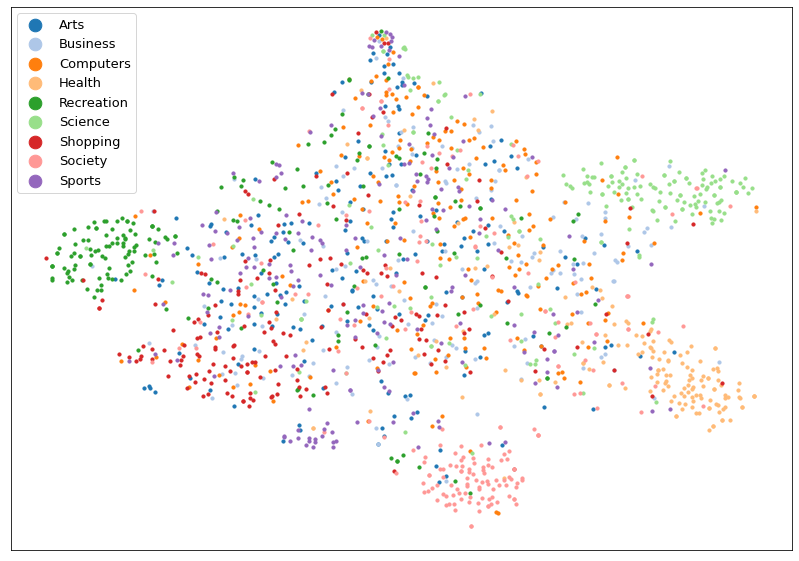

In [60]:
colormap = plt.get_cmap('tab20')
y_ = y.cpu()

opacity = 1
marker_size = 10
marker = 'o'

fig, ax = plt.subplots(figsize=(14, 10))

n = 0
ncat = len(categories)

for cat in categories:
    ix = (y_ == n).nonzero().flatten()
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

#ax.set_xlim([-80,100])
#ax.set_ylim([0,1])

ax.set_xticks([], [])
ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=4, fontsize=13)
plt.plot();